# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [1]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import pandas as pd

In [2]:
# input file containing the surface reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'

# cti_file = '../RMG-model/cantera/chem0050.cti'

gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [3]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [  +33 minor]              0                0



In [4]:
print(", ".join(gas.species_names))

Ne, H4N2O2(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), HO2(39), HNOH(94), N2H3(99), H3N2O(193), S(196), H2NO3(252), H2N2O(502), NNDO(506), S(566)


In [5]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), SX(215), H2NOX(217), H3NOX(218), HNO3X(221), CH3OX(223), CH4OX(224)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [6]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [7]:
#######################################################################
# Input Parameters for combustor
#######################################################################
mass_flow_rate =  0.5e-3 # kg/s
temperature_c = 400.0  # Initial Temperature in Celsius
pressure = ct.one_atm # constant

length = 1.1 * cm  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
cat_specific_area = 140 # m2/g
cat_density = 2 / cm**3 # 2 g/m3
print(f"Catalyst density {cat_density :.2e} g/m3")
cat_area_per_vol = cat_specific_area * cat_density # m2/m3
cat_area_per_vol *= 1e-1 # REDUCE BY 10x
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
print()

porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter

Catalyst density 2.00e+06 g/m3
Catalyst area per volume 2.80e+07 m2/m3



In [8]:
output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2001
# dt = 1.0

#####################################################################

temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# should this be mole fractions or mole fractions?
# 'H4N2O2(2):0.14, NH2OH(3):0.3, HNO3(4):0.3, CH3OH(5):0.16, H2O(6):0.04'
gas.TPY = temperature_kelvin, pressure, 'H4N2O2(2):0.0014, NH2OH(3):0.3, HNO3(4):0.3, CH3OH(5):0.16, H2O(6):0.04'


# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = temperature_kelvin, pressure
surf.coverages = 'X(1):1.0'

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['gas_heat','surface_heat','alpha'])

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)

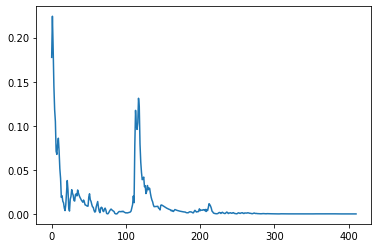


  surface1:

       temperature          673.15  K
          pressure          101325  Pa
           density     5.66009e-06  kg/m^3
  mean mol. weight         195.176  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy         -4854.8       -9.475e+05     J
   internal energy         -4854.8       -9.475e+05     J
           entropy          3.5086            684.8     J/K
    Gibbs function         -7216.6       -1.409e+06     J
 heat capacity c_p          1.0593            206.7     J/K
 heat capacity c_v          1.0593            206.7     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              X(1)       0.993635         0.993164      -0.00642421
            HX(26)     0.00300833       0.00302244         -11.5811
            OX(27)    5.05696e-08       5.4691e-08         -44.2441
           HOX(29)    1

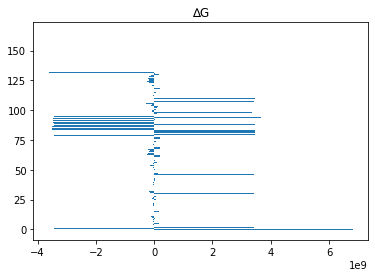

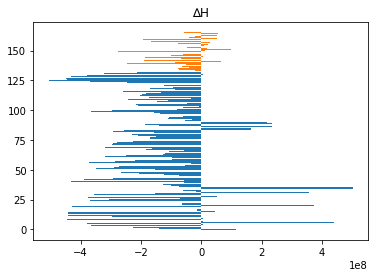

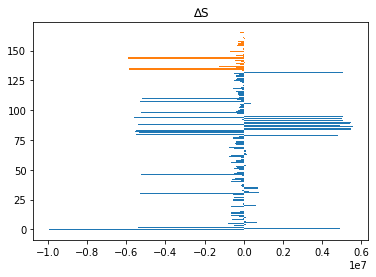

array([ 9.93635262e-01,  3.00832920e-03,  5.05695796e-08,  2.45113835e-16,
        1.82897719e-10,  4.42931333e-04,  1.54602000e-11,  2.91342606e-03,
        5.18633237e-12,  5.10049421e-17,  1.32803206e-10,  9.00253955e-63,
       -3.33358103e-25, -5.87444228e-25, -8.27641400e-34,  5.12156400e-12,
        1.86241758e-17])

In [9]:
# To find the starting coverages, we run the gas to equilibrium,
# (i.e mostly burned products)  then put that in steady state
# with the surface.
TPY = gas.TPY # store to restore
gas.equilibrate('TP')
r = ct.IdealGasReactor(gas, energy='off')
r.volume = r_vol
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
sim = ct.ReactorNet([r])
plt.plot(sim.advance_to_steady_state(return_residuals=True))
plt.show()
surf()
starting_coverages = surf.coverages

print("At equilibrium")
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

gas.TPY = TPY # restore to starting conditions
del(r, rsurf)
starting_coverages

<BarContainer object of 34 artists>

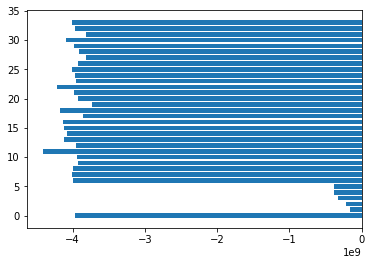

In [10]:
plt.barh(np.arange(len(gas.chemical_potentials)),gas.chemical_potentials)

In [11]:
# gas.equilibrate('TP')

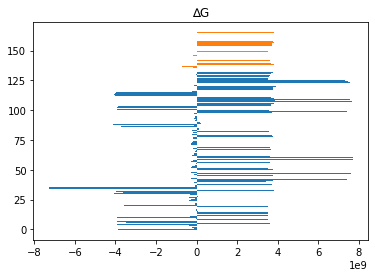

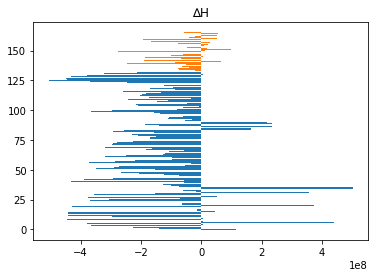

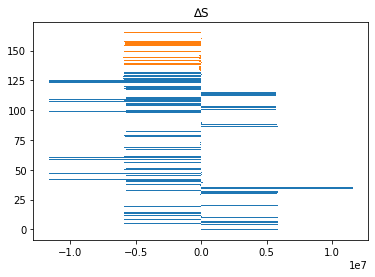

In [12]:
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

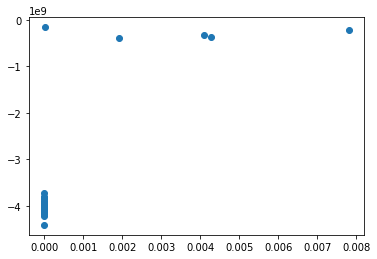

In [13]:
plt.plot(gas.concentrations, gas.chemical_potentials, 'o')

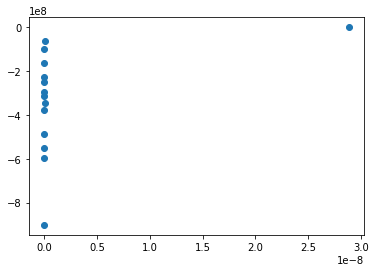

In [14]:
plt.plot(surf.concentrations, surf.chemical_potentials, 'o')

In [15]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of reactor (though porosity not yet accounted for)")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
 60 : H3N2O(193) + OH(24) <=> H4N2O2(2)                   -8e+04
 59 : H3N2O(193) + OH(24) <=> H4N2O2(2)                   -8e+04
107 : HO2(39) + N2H3(99) <=> H4N2O2(2)                        -1
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)               -0.002
109 : H(20) + S(196) <=> H4N2O2(2)                        -1e-07
123 : H2NO3(252) + S(196) <=> H4N2O2(2) + HNO3(4)         -8e-08
124 : H2NO3(252) + HNOH(94) <=> HNO3(4) + NH2OH(3)        -2e-15

Highest net rates of progress, surface
  0 : H2O(6) + X(1) <=> H2OX(30)                          -5e+07
  1 : NH2OH(3) + X(1) <=> H3NOX(218)                       4e+06
  3 : CH3OH(5) + X(1) <=> CH4OX(224)                       2e+06
  2 : HNO3(4) + X(1) <=> HNO3X(221)                        1e+06
  5 : H2(13) + 2 X(1) <=> 2 HX(26)                        -2e+04
  4 : H4N2O2(2) + X(1) <=> SX(215)                         6e+03
 10 : NH2OH(3) + 2 X(1) <=> H2NOX(217) + HX(26)            4e+02

Highest forwa

In [16]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
129 : H2NO3(252) + HCO(22) <=> CH2O(17) + HNO3(4)        1.8e+11
 40 : HCO(22) + OH(24) <=> CO(14) + H2O(6)               1.1e+11
 24 : H(20) + HCO(22) <=> CO(14) + H2(13)                1.1e+11
 46 : H(20) + NO2(9) <=> NO(10) + OH(24)                 9.9e+10
 19 : C2H5(21) + H(20) (+M) <=> C2H6(16) (+M)            9.2e+10
 68 : C2H5(21) + H2N2O(502) <=> C2H4(25) + H3N2O(193)    9.0e+10
 58 : C2H5(21) + HCO(22) <=> C2H4(25) + CH2O(17)         6.5e+10

Highest forward rate constants, surface
 30 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 29 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 31 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 17 : HX(26) + OX(27) <=> HOX(29) + X(1)                 1.7e+19
 26 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18
 28 : CO2X(31) + HX(26) <=> HOX(29) + OCX(32)            2.2e+17
 23 : CH4(15) + HOX(29) + X(1) <=> CH3X(28) + H2OX(30)   4.7e+16

Highest rev

In [17]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='on')
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-11
sim.atol = 1.0e-20

sim.verbose = False

# surf.set_multiplier(0.)  # turn off surface reactions
# surf.set_multiplier(1e6)  # make surface reactions a million times faster


print('    distance(mm)     H4N2O2(2)   NH2OH(3)   HNO3(4)  CH3OH(5)  alpha')
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY

    upstream.syncState()
    sim.reinitialize()
    try:
#         the default is residual_threshold = sim.rtol*10
#         sim.advance_to_steady_state(residual_threshold = sim.rtol*1e3)
        sim.advance_to_steady_state()

    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        r.syncState()
        sim.reinitialize()
        print(f"Couldn't reach {t:.1g} s so going to {0.1*t:.1g} s")
        sim.advance(0.1*t)
        report_rates()
        report_rate_constants()
 
    dist = n * r_len * 1.0e3   # distance in mm
        
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surface_heat = cat_area_per_vol * np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = surface_heat / (surface_heat + gas_heat) # fraction of heat release that is on surface.

    if not n % 10:
        print('    {:10f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, *gas['H4N2O2(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [gas_heat, surface_heat, alpha])
    
    #report_rates()
    #report_rate_constants()

outfile.close()
print("Results saved to '{0}'".format(output_filename))

    distance(mm)     H4N2O2(2)   NH2OH(3)   HNO3(4)  CH3OH(5)  alpha
Couldn't reach 7e-10 s so going to 7e-11 s

Highest net rates of progress, gas
 60 : H3N2O(193) + OH(24) <=> H4N2O2(2)                   -1e+03
 59 : H3N2O(193) + OH(24) <=> H4N2O2(2)                   -1e+03
 97 : NH2OH(3) + OH(24) <=> H2O(6) + HNOH(94)              7e+02
 67 : H3N2O(193) + OH(24) <=> H2N2O(502) + H2O(6)              9
108 : H3N2O(193) + OH(24) <=> S(566)                           4
 76 : H2N2O(502) => NNDO(506)                                  4
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)                   -1

Highest net rates of progress, surface
  3 : CH3OH(5) + X(1) <=> CH4OX(224)                      -5e+06
  2 : HNO3(4) + X(1) <=> HNO3X(221)                        5e+05
  1 : NH2OH(3) + X(1) <=> H3NOX(218)                       2e+05
  5 : H2(13) + 2 X(1) <=> 2 HX(26)                        -1e+05
  0 : H2O(6) + X(1) <=> H2OX(30)                          -7e+04
  9 : OH(24) + X(1) <=> HOX(29) 

      0.055000    0.000000    0.416627    0.205602   0.134340  5.6e-01
      0.110000    0.000000    0.407312    0.196821   0.111194  4.6e-01
      0.165000    0.000000    0.401869    0.191393   0.097916  3.8e-01
      0.220000    0.000000    0.398044    0.187420   0.088720  3.1e-01
      0.275000    0.000000    0.395104    0.184264   0.081740  2.4e-01
      0.330000    0.000000    0.392719    0.181629   0.076143  1.7e-01
      0.385000    0.000000    0.390714    0.179356   0.071491  9.5e-02
      0.440000    0.000000    0.388986    0.177349   0.067521  1.9e-02
      0.495000    0.000000    0.387466    0.175546   0.064066  -6.2e-02
      0.550000    0.000000    0.386110    0.173902   0.061013  -1.5e-01
      0.605000    0.000000    0.384884    0.172387   0.058283  -2.4e-01
      0.660000    0.000000    0.383767    0.170979   0.055817  -3.4e-01
      0.715000    0.000000    0.382738    0.169659   0.053570  -4.6e-01
      0.770000    0.000000    0.381785    0.168414   0.051508  -5.8e-01


      6.380000    0.000000    0.283192    0.000000   0.000000  -2.1e-01
      6.435000    0.000000    0.283135    0.000000   0.000000  -1.5e-01
      6.490000    0.000000    0.283077    0.000000   0.000000  -1.0e-01
      6.545000    0.000000    0.283019    0.000000   0.000000  -6.3e-02
      6.600000    0.000000    0.282960    0.000000   0.000000  -3.1e-02
      6.655000    0.000000    0.282900    0.000000   0.000000  -4.2e-03
      6.710000    0.000000    0.282841    0.000000   0.000000  1.8e-02
      6.765000    0.000000    0.282780    0.000000   0.000000  3.7e-02
      6.820000    0.000000    0.282720    0.000000   0.000000  5.3e-02
      6.875000    0.000000    0.282659    0.000000   0.000000  6.6e-02
      6.930000    0.000000    0.282597    0.000000   0.000000  7.8e-02
      6.985000    0.000000    0.282536    0.000000   0.000000  8.8e-02
      7.040000    0.000000    0.282474    0.000000   0.000000  9.6e-02
      7.095000    0.000000    0.282411    0.000000   0.000000  1.0e-01


In [18]:
sim.time

903.364276484723

In [19]:
gas.TDY = TDY
r.syncState()
r.thermo.T

1478.5254581762358

In [20]:
r.thermo.X - gas.X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
rsurf.kinetics.net_rates_of_progress

array([ 3.89276301e-04,  6.01484477e-05,  2.39120036e-13,  1.02420017e-16,
        2.30566845e-24,  2.42198270e-05, -2.00692553e-08,  1.47472351e-10,
        5.25924869e-09,  2.10549092e-08,  3.41207198e-07,  1.73760440e-06,
       -1.63312119e-11,  1.13367191e-18,  6.63948239e-22,  2.46275294e-18,
        2.29975965e-10,  5.98310637e-08, -7.15809423e-11, -2.12244669e-13,
        1.27384328e-24,  9.20726672e-14,  3.14437724e-15,  1.81350552e-15,
        3.82333852e-07,  1.10604956e-04,  3.28911143e-11,  4.26078348e-10,
       -2.83772844e-10,  6.26622740e-12, -1.37640289e-07, -4.21367953e-05,
        2.39434221e-12])

In [22]:
surf.net_rates_of_progress

array([ 3.89276301e-04,  6.01484477e-05,  2.39120036e-13,  1.02420017e-16,
        2.30566845e-24,  2.42198270e-05, -2.00692553e-08,  1.47472351e-10,
        5.25924869e-09,  2.10549092e-08,  3.41207198e-07,  1.73760440e-06,
       -1.63312119e-11,  1.13367191e-18,  6.63948239e-22,  2.46275294e-18,
        2.29975965e-10,  5.98310637e-08, -7.15809423e-11, -2.12244669e-13,
        1.27384328e-24,  9.20726672e-14,  3.14437724e-15,  1.81350552e-15,
        3.82333852e-07,  1.10604956e-04,  3.28911143e-11,  4.26078348e-10,
       -2.83772844e-10,  6.26622740e-12, -1.37640289e-07, -4.21367953e-05,
        2.39434221e-12])

In [23]:
gas.TDY

(1478.5254581762358,
 0.20264724268987613,
 array([1.71077186e-310, 3.88684728e-020, 3.73204321e-001, 1.82139889e-009,
        5.43837259e-013, 2.16441942e-001, 4.66609928e-315, 8.86811552e-009,
        2.93359872e-002, 1.62873589e-001, 0.00000000e+000, 1.11728174e-001,
        1.09564552e-002, 7.77559384e-002, 9.93819173e-009, 4.57693173e-016,
        3.71323031e-009, 7.23686587e-012, 1.10464790e-023, 2.02976164e-007,
        1.33148883e-018, 5.22700540e-010, 2.94087615e-010, 2.98057674e-007,
        1.94773488e-013, 1.64481369e-008, 1.68434946e-002, 2.60119831e-008,
        1.03087818e-008, 1.14522657e-015, 2.73639810e-012, 3.67847126e-015,
        8.59520496e-004, 1.85818522e-019]))

In [24]:
r.thermo.TDY

(1478.5254581762358,
 0.20264724268987613,
 array([1.71077186e-310, 3.88684728e-020, 3.73204321e-001, 1.82139889e-009,
        5.43837259e-013, 2.16441942e-001, 4.66609928e-315, 8.86811552e-009,
        2.93359872e-002, 1.62873589e-001, 0.00000000e+000, 1.11728174e-001,
        1.09564552e-002, 7.77559384e-002, 9.93819173e-009, 4.57693173e-016,
        3.71323031e-009, 7.23686587e-012, 1.10464790e-023, 2.02976164e-007,
        1.33148883e-018, 5.22700540e-010, 2.94087615e-010, 2.98057674e-007,
        1.94773488e-013, 1.64481369e-008, 1.68434946e-002, 2.60119831e-008,
        1.03087818e-008, 1.14522657e-015, 2.73639810e-012, 3.67847126e-015,
        8.59520496e-004, 1.85818522e-019]))

In [25]:
report_rate_constants()


Highest forward rate constants, gas
129 : H2NO3(252) + HCO(22) <=> CH2O(17) + HNO3(4)        1.8e+11
 46 : H(20) + NO2(9) <=> NO(10) + OH(24)                 1.1e+11
 40 : HCO(22) + OH(24) <=> CO(14) + H2O(6)               1.1e+11
 24 : H(20) + HCO(22) <=> CO(14) + H2(13)                1.1e+11
 68 : C2H5(21) + H2N2O(502) <=> C2H4(25) + H3N2O(193)    9.0e+10
109 : H(20) + S(196) <=> H4N2O2(2)                       7.3e+10
 99 : H(20) + HNOH(94) <=> NH2OH(3)                      7.3e+10

Highest forward rate constants, surface
 30 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 29 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 31 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 17 : HX(26) + OX(27) <=> HOX(29) + X(1)                 5.1e+19
 26 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18
  7 : HOX(29) + HX(26) <=> H2OX(30) + X(1)               9.3e+17
 28 : CO2X(31) + HX(26) <=> HOX(29) + OCX(32)            5.0e+17

Highest rev

In [26]:
sim.verbose

False

In [27]:
sim.component_name(46)

'IdealGasReactor_2: CH2X(34)'

<BarContainer object of 133 artists>

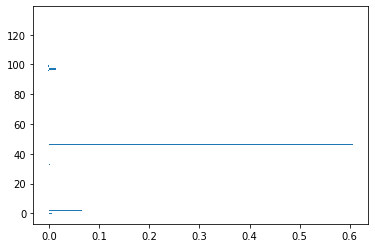

In [28]:
plt.barh(np.arange(len(gas.net_rates_of_progress)),gas.net_rates_of_progress)

In [29]:
gas.T

1478.5254581762358

In [30]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ne,H4N2O2(2),NH2OH(3),HNO3(4),CH3OH(5),H2O(6),N2(7),...,CHX(35),SX(215),H2NOX(217),H3NOX(218),HNO3X(221),CH3OX(223),CH4OX(224),gas_heat,surface_heat,alpha
0,0.0000,576.263350,1.271909,0.000000e+00,5.513499e-07,0.405072,2.118876e-01,2.465326e-01,0.134219,0.000000e+00,...,1.063252e-10,5.842660e-07,3.303392e-07,0.002300,9.305277e-04,1.315820e-06,4.370101e-04,9.404537e+10,1.348587e+14,0.999303
1,0.0055,755.186351,0.999800,0.000000e+00,9.017882e-12,0.441592,2.265278e-01,1.978433e-01,0.114205,0.000000e+00,...,6.116637e-11,4.532716e-15,7.492236e-05,0.000353,1.850194e-04,8.402491e-05,3.600381e-05,6.711312e+09,-5.617850e+11,1.012091
2,0.0110,741.493883,1.000000,0.000000e+00,6.848160e-13,0.435683,2.219983e-01,1.830646e-01,0.114355,0.000000e+00,...,6.485300e-08,2.856500e-16,3.070545e-04,0.000310,1.623566e-04,2.034597e-01,2.813715e-05,7.843906e+09,1.965689e+10,0.714775
3,0.0165,731.509590,1.000000,0.000000e+00,5.811125e-13,0.431534,2.185814e-01,1.722931e-01,0.114530,0.000000e+00,...,1.196859e-07,2.626529e-16,2.847525e-04,0.000338,1.764547e-04,1.937853e-01,2.800077e-05,6.421064e+09,1.355725e+10,0.678598
4,0.0220,723.612722,1.000000,0.000000e+00,5.268894e-13,0.428261,2.158299e-01,1.638641e-01,0.114733,0.000000e+00,...,1.817967e-07,2.534610e-16,2.722760e-04,0.000361,1.882116e-04,1.877868e-01,2.778996e-05,5.450778e+09,1.030326e+10,0.654008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,10.9780,1205.227565,1.000000,2.084337e-310,1.489805e-20,0.277814,7.129550e-10,4.174295e-13,0.295340,4.095230e-315,...,1.357857e-07,9.774519e-25,3.432035e-05,0.000018,4.284754e-14,3.014570e-14,2.155610e-17,-9.627255e+07,-9.450751e+06,0.089391
1997,10.9835,1205.276900,1.000000,2.084332e-310,1.490579e-20,0.277808,7.121900e-10,4.173817e-13,0.295355,4.095217e-315,...,1.356960e-07,9.778224e-25,3.431856e-05,0.000018,4.279327e-14,3.013889e-14,2.155176e-17,-9.620863e+07,-9.434026e+06,0.089301
1998,10.9890,1205.326198,1.000000,2.084326e-310,1.491353e-20,0.277802,7.114255e-10,4.173340e-13,0.295369,4.095205e-315,...,1.356064e-07,9.781928e-25,3.431678e-05,0.000018,4.273905e-14,3.013208e-14,2.154743e-17,-9.614466e+07,-9.418325e+06,0.089220
1999,10.9945,1205.375458,1.000000,2.084320e-310,1.492127e-20,0.277796,7.106615e-10,4.172864e-13,0.295384,4.095189e-315,...,1.355169e-07,9.785631e-25,3.431499e-05,0.000018,4.268488e-14,3.012529e-14,2.154310e-17,-9.608065e+07,-9.402139e+06,0.089134


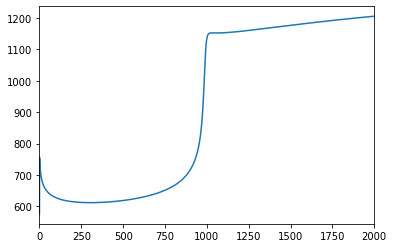

In [31]:
data['T (C)'].plot()

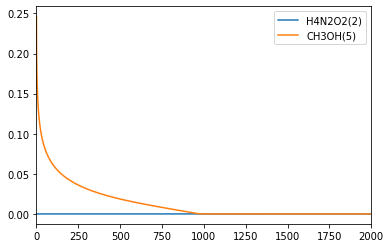

In [32]:
data[['H4N2O2(2)', 'CH3OH(5)']].plot()

In [33]:
list(data.columns)[:4]

['Distance (mm)', 'T (C)', 'P (atm)', 'Ne']

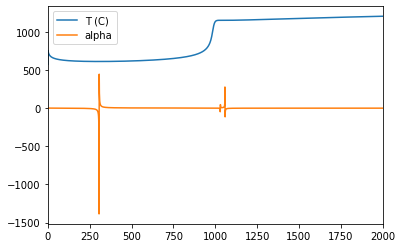

In [34]:
data[['T (C)', 'alpha']].plot()

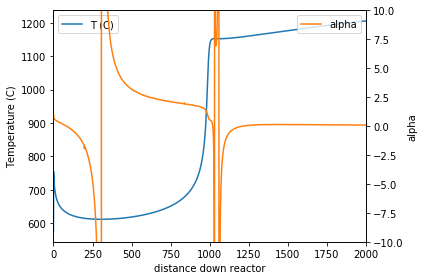

In [35]:
ax1 = data['T (C)'].plot()
plt.xlabel('distance down reactor')
plt.ylabel('Temperature (C)')
plt.legend()
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, color='tab:orange')
ax2.set_ylim(-10, 10)
plt.legend()
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('temperature-and-alpha.pdf')
plt.show()

In [36]:
data.columns

Index(['Distance (mm)', 'T (C)', 'P (atm)', 'Ne', 'H4N2O2(2)', 'NH2OH(3)',
       'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)', 'O2(8)', 'NO2(9)', 'NO(10)',
       'N2O(11)', 'CO2(12)', 'H2(13)', 'CO(14)', 'CH4(15)', 'C2H6(16)',
       'CH2O(17)', 'CH3(18)', 'C3H8(19)', 'H(20)', 'C2H5(21)', 'HCO(22)',
       'CH3CHO(23)', 'OH(24)', 'C2H4(25)', 'HO2(39)', 'HNOH(94)', 'N2H3(99)',
       'H3N2O(193)', 'S(196)', 'H2NO3(252)', 'H2N2O(502)', 'NNDO(506)',
       'S(566)', 'X(1)', 'HX(26)', 'OX(27)', 'CH3X(28)', 'HOX(29)', 'H2OX(30)',
       'CO2X(31)', 'OCX(32)', 'CX(33)', 'CH2X(34)', 'CHX(35)', 'SX(215)',
       'H2NOX(217)', 'H3NOX(218)', 'HNO3X(221)', 'CH3OX(223)', 'CH4OX(224)',
       'gas_heat', 'surface_heat', 'alpha'],
      dtype='object')

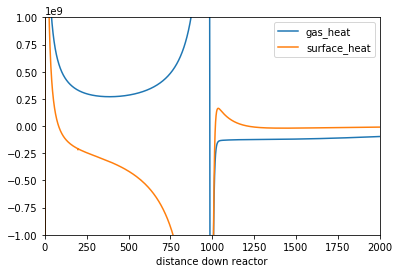

In [37]:
data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
plt.xlabel('distance down reactor')
plt.savefig('gas_and_surface_heat.pdf')
plt.show()


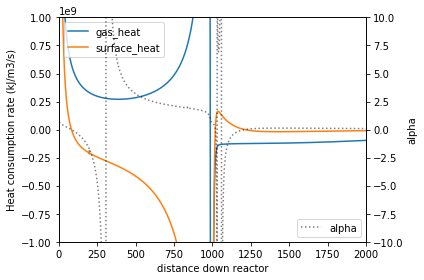

In [56]:
ax1 = data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
plt.xlabel('distance down reactor')
plt.ylabel('Heat consumption rate (kJ/m3/s)')
plt.legend(loc='upper left')
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, style='k:', alpha=0.5)
ax2.set_ylim(-10, 10)
plt.legend(loc='lower right')
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('heats-and-alpha.pdf')
plt.show()

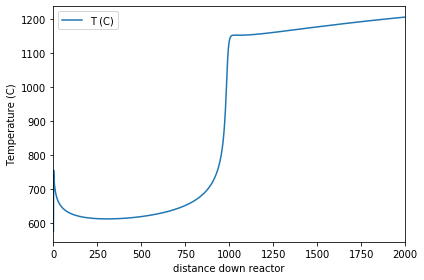

In [59]:
data[['T (C)']].plot()
plt.ylabel('Temperature (C)')
plt.xlabel('distance down reactor')
plt.tight_layout()
plt.savefig('temperature.pdf')
plt.show()

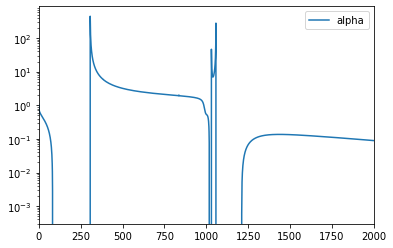

In [38]:
data[['alpha']].plot(logy=True)

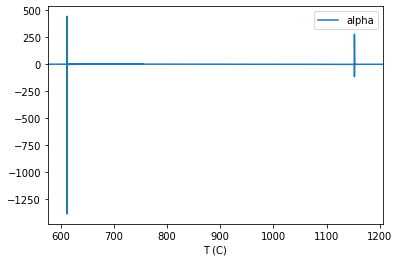

In [39]:
data.plot(x='T (C)',y='alpha')

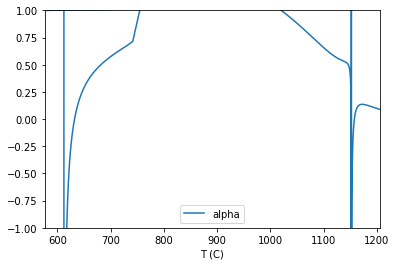

In [40]:
data.plot(x='T (C)',y='alpha', ylim=(-1,1))

In [41]:
specs = list(data.columns)
specs = specs[4:-1]

gas_species = [s for s in specs if 'X' not in s]
adsorbates = [s for s in specs if 'X' in s]

gas_species, adsorbates

(['H4N2O2(2)',
  'NH2OH(3)',
  'HNO3(4)',
  'CH3OH(5)',
  'H2O(6)',
  'N2(7)',
  'O2(8)',
  'NO2(9)',
  'NO(10)',
  'N2O(11)',
  'CO2(12)',
  'H2(13)',
  'CO(14)',
  'CH4(15)',
  'C2H6(16)',
  'CH2O(17)',
  'CH3(18)',
  'C3H8(19)',
  'H(20)',
  'C2H5(21)',
  'HCO(22)',
  'CH3CHO(23)',
  'OH(24)',
  'C2H4(25)',
  'HO2(39)',
  'HNOH(94)',
  'N2H3(99)',
  'H3N2O(193)',
  'S(196)',
  'H2NO3(252)',
  'H2N2O(502)',
  'NNDO(506)',
  'S(566)',
  'gas_heat',
  'surface_heat'],
 ['X(1)',
  'HX(26)',
  'OX(27)',
  'CH3X(28)',
  'HOX(29)',
  'H2OX(30)',
  'CO2X(31)',
  'OCX(32)',
  'CX(33)',
  'CH2X(34)',
  'CHX(35)',
  'SX(215)',
  'H2NOX(217)',
  'H3NOX(218)',
  'HNO3X(221)',
  'CH3OX(223)',
  'CH4OX(224)'])

/Users/rwest/opt/anaconda3/envs/rmg3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


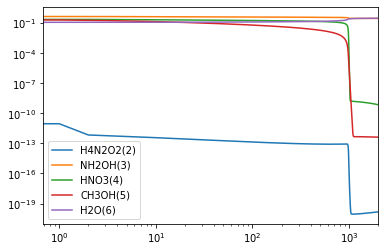

In [42]:
data[gas_species[0:5]].plot(logy=True, logx=True)

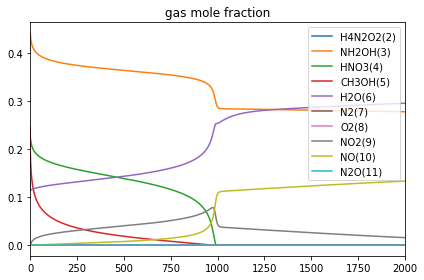

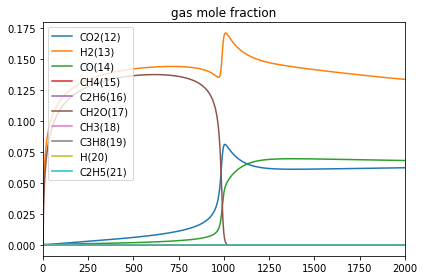

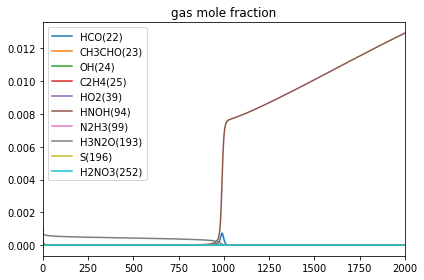

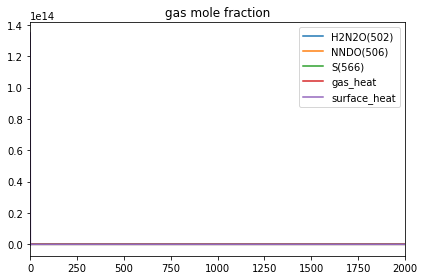

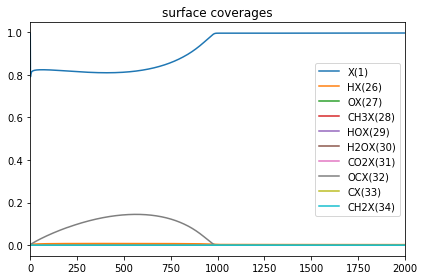

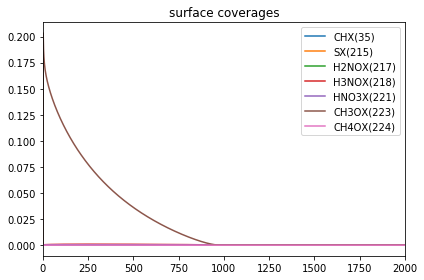

In [61]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='gas mole fraction', logy=False)
    plt.tight_layout()
    plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='surface coverages', logy=False)
    plt.tight_layout()
    plt.savefig(f'surface_coverages_{i}.pdf')
    plt.show()

In [44]:
gas.species('NO2(9)').composition

{'N': 1.0, 'O': 2.0}

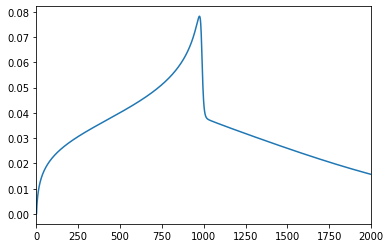

In [45]:
data['NO2(9)'].plot()

In [46]:
(data[specs].max()>0.01)

H4N2O2(2)       False
NH2OH(3)         True
HNO3(4)          True
CH3OH(5)         True
H2O(6)           True
N2(7)           False
O2(8)           False
NO2(9)           True
NO(10)           True
N2O(11)         False
CO2(12)          True
H2(13)           True
CO(14)           True
CH4(15)         False
C2H6(16)        False
CH2O(17)         True
CH3(18)         False
C3H8(19)        False
H(20)           False
C2H5(21)        False
HCO(22)         False
CH3CHO(23)      False
OH(24)          False
C2H4(25)        False
HO2(39)         False
HNOH(94)         True
N2H3(99)        False
H3N2O(193)      False
S(196)          False
H2NO3(252)      False
H2N2O(502)      False
NNDO(506)       False
S(566)          False
X(1)             True
HX(26)          False
OX(27)          False
CH3X(28)        False
HOX(29)         False
H2OX(30)        False
CO2X(31)        False
OCX(32)          True
CX(33)          False
CH2X(34)        False
CHX(35)         False
SX(215)         False
H2NOX(217)

In [47]:
data.loc[0]

Distance (mm)    0.000000e+00
T (C)            5.762634e+02
P (atm)          1.271909e+00
Ne               0.000000e+00
H4N2O2(2)        5.513499e-07
NH2OH(3)         4.050721e-01
HNO3(4)          2.118876e-01
CH3OH(5)         2.465326e-01
H2O(6)           1.342185e-01
N2(7)            0.000000e+00
O2(8)            1.155152e-12
NO2(9)           2.650506e-09
NO(10)           1.690835e-16
N2O(11)          0.000000e+00
CO2(12)          8.991793e-10
H2(13)           3.537740e-04
CO(14)           1.266773e-06
CH4(15)          2.188555e-20
C2H6(16)         1.663735e-41
CH2O(17)         2.440853e-14
CH3(18)          7.931946e-20
C3H8(19)         9.278466e-67
H(20)            1.159113e-10
C2H5(21)         4.049694e-45
HCO(22)          8.961667e-20
CH3CHO(23)       2.445439e-41
OH(24)           9.474448e-04
C2H4(25)         3.147798e-43
HO2(39)          3.701833e-08
HNOH(94)         1.948278e-06
N2H3(99)         3.701949e-08
H3N2O(193)       9.839988e-04
S(196)           4.493661e-15
H2NO3(252)